In [45]:
if 'google.colab' in str(get_ipython()):
    print('Downloading plot_helpers.py to util/ (only neded for colab')
    !mkdir util; wget https://raw.githubusercontent.com/minireference/noBSLAnotebooks/master/util/plot_helpers.py -P util

In [46]:
from autograd import numpy
from autograd import grad
from matplotlib import pyplot

In [47]:
from urllib.request import urlretrieve
URL = 'https://github.com/engineersCode/EngComp6_deeplearning/raw/master/data/casting_images.npz'
urlretrieve(URL, 'casting_images.npz')


('casting_images.npz', <http.client.HTTPMessage at 0x25bc2932748>)

In [48]:
with numpy.load("casting_images.npz",allow_pickle=True) as data:
    ok_images = data["ok_images"]
    def_images = data["def_images"]

In [49]:
type(ok_images)

numpy.ndarray

In [50]:
ok_images.shape

(519, 16384)

In [51]:
n_ok_total = ok_images.shape[0]
res = int(numpy.sqrt(def_images.shape[1]))

print("Number of images without defects:",n_ok_total)
print("Image resolution: {} by {}".format(res,res))

Number of images without defects: 519
Image resolution: 128 by 128


In [52]:
n_def_total = def_images.shape[0]
print("Number of umages with defects:",n_def_total)

Number of umages with defects: 781


Text(0.5, 0.98, 'Casting parts without defects')

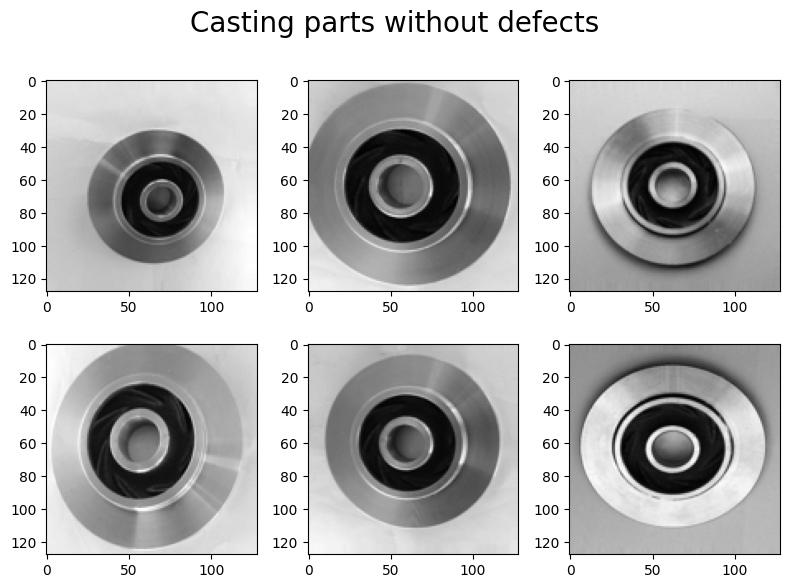

In [53]:
fig, axes = pyplot.subplots(2,3,figsize=(8,6),tight_layout=True)
axes[0, 0].imshow(ok_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(ok_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(ok_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(ok_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(ok_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(ok_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts without defects", fontsize=20)

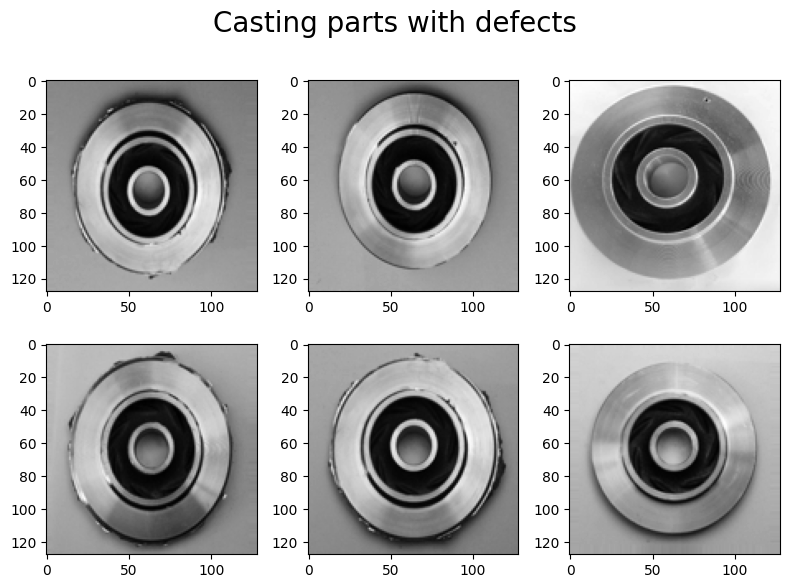

In [54]:
fig, axes = pyplot.subplots(2, 3, figsize=(8, 6), tight_layout=True)
axes[0, 0].imshow(def_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(def_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(def_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(def_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(def_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(def_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts with defects", fontsize=20);

In [55]:
def logistic(x):
    out = 1. / (1. + numpy.exp(-x))
    return out

In [56]:
def logistic_model(x,params):
    out = logistic(numpy.dot(x,params[0])+params[1])

    return out

In [57]:
def model_loss(x,true_labels,params,_lambda=1.0):
    pred = logistic_model(x,params)
    loss = -(numpy.dot(true_labels,numpy.log(pred+1e-15))+numpy.dot(1.-true_labels,numpy.log(1.-pred+1e-15))) \
    +_lambda * numpy.sum(params[0]**2)
    return loss

In [58]:
# numbers of images for validation (~ 20%)
n_ok_val = int(n_ok_total * 0.2)
n_def_val = int(n_def_total * 0.2)
print("Number of images without defects in validation dataset:", n_ok_val)
print("Number of images with defects in validation dataset:", n_def_val)

# numbers of images for test (~ 20%)
n_ok_test = int(n_ok_total * 0.2)
n_def_test = int(n_def_total * 0.2)
print("Number of images without defects in test dataset:", n_ok_test)
print("Number of images with defects in test dataset:", n_def_test)

# remaining images for training (~ 60%)
n_ok_train = n_ok_total - n_ok_val - n_ok_test
n_def_train = n_def_total - n_def_val - n_def_test
print("Number of images without defects in training dataset:", n_ok_train)
print("Number of images with defects in training dataset:", n_def_train)

Number of images without defects in validation dataset: 103
Number of images with defects in validation dataset: 156
Number of images without defects in test dataset: 103
Number of images with defects in test dataset: 156
Number of images without defects in training dataset: 313
Number of images with defects in training dataset: 469


In [59]:
ok_images = numpy.split(ok_images,[n_ok_val,n_ok_val+n_ok_test],0)
def_images = numpy.split(def_images,[n_def_val,n_def_val+n_def_test],0)

In [60]:
images_val = numpy.concatenate([ok_images[0],def_images[0]],0)
images_test = numpy.concatenate([ok_images[1],def_images[1]],0)
images_train = numpy.concatenate([ok_images[2],def_images[2]],0)

In [61]:
mu = numpy.mean(images_train,axis=0)
sigma = numpy.std(images_train,axis=0)

images_train = (images_train - mu) / sigma
images_val = (images_val - mu) / sigma
images_test = (images_test - mu) / sigma


In [62]:
# labels for training data
labels_train = numpy.zeros(n_ok_train+n_def_train)
labels_train[n_ok_train:] = 1.

# labels for validation data
labels_val = numpy.zeros(n_ok_val+n_def_val)
labels_val[n_ok_val:] = 1.

# labels for test data
labels_test = numpy.zeros(n_ok_test+n_def_test)
labels_test[n_ok_test:] = 1.

In [63]:
def classify(x,params):
    probabilities = logistic_model(x,params)
    labels = (probabilities >= 0.5).astype(float)
    return labels

In [64]:

def performance(predictions,answers,beta=1.0):
    true_idx = (answers == 1)
    false_idx = (answers == 0)

    # true positive: answers are 1 and predictions are also 1
    n_tp = numpy.count_nonzero(predictions[true_idx] == 1)
    
    # false positive: answers are 0 but predictions are 1
    n_fp = numpy.count_nonzero(predictions[false_idx] == 1)
    
    # true negative: answers are 0 and predictions are also 0
    n_tn = numpy.count_nonzero(predictions[false_idx] == 0)
    
    # false negative: answers are 1 but predictions are 0
    n_fn = numpy.count_nonzero(predictions[true_idx] == 0)

    # precision, recall, and f-score
    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    score = (
        (1.0 + beta**2) * precision * recall / 
        (beta**2 * precision + recall)
    )

    accuracy = (n_tp + n_tn) / (n_tp + n_fn + n_fp + n_tn)

    return precision, recall, score, accuracy

In [65]:
gradients = grad(model_loss,argnum=2)

w = numpy.zeros(images_train.shape[1],dtype=float)
b=0.

In [66]:
pred_labels_test = classify(images_test,(w,b))
perf = performance(pred_labels_test,labels_test)

print("Initial precision: {:.1f}%".format(perf[0]*100))
print("Initial recall: {:.1f}%".format(perf[1]*100))
print("Initial F-score: {:.1f}%".format(perf[2]*100))
print("Initial Accuracy: {:.1f}%".format(perf[3]*100))

Initial precision: 60.2%
Initial recall: 100.0%
Initial F-score: 75.2%
Initial Accuracy: 60.2%


In [68]:
lr = 1e-5

change = numpy.Inf

i = 0

old_val_loss = 1e-15

while change >= 1e-5 and i<10000:
    grads = gradients(images_train,labels_train,(w,b))
    w -= (grads[0] * lr)
    b -= (grads[1] * lr)

    val_loss = model_loss(images_val, labels_val,(w,b))

    pred_labels_val = classify(images_val,(w,b))
    score = performance(pred_labels_val,labels_val)

    change = numpy.abs((val_loss-old_val_loss)/old_val_loss)

    i += 1
    old_val_loss = val_loss
    
    if i % 10 == 0:
        print("{}...".format(i),end="")

print("")
print("")
print("Upon optimization stopped:")
print("    Iterations:", i)
print("    Validation loss:", val_loss)
print("    Validation precision:", score[0])
print("    Validation recall:", score[1])
print("    Validation F-score:", score[2])
print("    Validation Accuracy:", score[3])
print("    Change in validation loss:", change)


10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...360...370...380...390...400...410...420...430...440...450...460...470...480...490...500...510...520...530...540...

Upon optimization stopped:
    Iterations: 540
    Validation loss: 126.77521474139662
    Validation precision: 0.900709219858156
    Validation recall: 0.8141025641025641
    Validation F-score: 0.8552188552188552
    Validation Accuracy: 0.833976833976834
    Change in validation loss: 2.0796231712873545e-06


In [69]:
pred_labels_test = classify(images_test,(w,b))
perf = performance(pred_labels_test,labels_test)

print("Final precision: {:.1f}%".format(perf[0]*100))
print("Final recall: {:.1f}%".format(perf[1]*100))
print("Final F-score: {:.1f}%".format(perf[2]*100))
print("Final Accuracy: {:.1f}%".format(perf[3]*100))

Final precision: 88.0%
Final recall: 84.6%
Final F-score: 86.3%
Final Accuracy: 83.8%
